## Comparing DLC Camera CSV 3D coordinate Data to Autobender/Rotary Encoder

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
from config import path_to_repository
from analysis import DLC3DBendAngles
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [109]:
#load rotary encoder csv, camera 3d data form DLC csv, and flir_data.mat with timestamps from python camera acquisition

renc = os.path.join(path_to_repository , "CSV Data/8_20_25/data_rotenc_2025_08_20_18_37_05.csv")
df_renc = pd.read_csv(renc)  
cam = os.path.join(path_to_repository , "CSV Data/8_20_25/camera-1-2025_08_20_18_37_05DLC_Resnet50_0815Aug16shuffle1_snapshot_010.csv")
cam_timestamp = os.path.join(
    path_to_repository,
    "CSV Data/8_20_25/flir_data.mat"
)



In [110]:
#load DLC 3d coordinates from DLC triangulation
cam = DLC3DBendAngles(cam)

# Load only variables starting with 'ts' -> timestamp data
df_ts = cam.load_mat_as_df(cam_timestamp, prefix="ts")

In [111]:
#check number of rows from  cam dataframe (taken from DLC csv) and df_ts dataframe (timestamps form flir_data.mat file).  They hopefully are the same.  If not, need to determine which frames dropped.
rows_renc, rows_cam = DLC3DBendAngles.compare_row_counts(cam.df, df_ts)

DataFrame 1: 199 rows
DataFrame 2: 199 rows


In [112]:
#add camera timestamp columns to 3d dlc data
cam.add_dataframe(df_ts)

scorer DLC_Resnet50_0815Aug16shuffle1_snapshot_010             \
    bodyparts                                         PIP              
       coords                                           x          y   
0           0                                   307.73752  193.31961   
1           1                                   307.50560  192.59079   
2           2                                   308.78305  193.86148   
3           3                                   308.48132  194.70093   
4           4                                   308.92087  195.95807   
..        ...                                         ...        ...   
194       194                                   298.12952  179.40508   
195       195                                   297.68942  179.18030   
196       196                                   297.72340  177.35709   
197       197                                   298.82860  180.25078   
198       198                                   299.31534  180.12654   

                                                                       \
                      MCP                             hand              
    likelihood          x          y likelihood          x          y   
0     0.836859  775.40580  351.82690   0.890922  908.46075  411.82083   
1     0.857537  774.85205  351.46730   0.914274  907.62994  411.06310   
2     0.823181  776.88873  352.50070   0.857445  910.04517  412.62286   
3     0.766269  776.82050  352.48590   0.861685  910.23590  412.89320   
4     0.761887  776.97380  351.78076   0.862475  910.39860  413.50960   
..         ...        ...        ...        ...        ...        ...   
194   0.783905  762.90690  340.92920   0.885881  896.01340  403.86120   
195   0.780676  761.56290  340.37990   0.839201  894.78595  403.38690   
196   0.777392  762.33057  339.83698   0.857828  895.57336  402.31506   
197   0.793611  763.03217  342.71356   0.906831  896.37170  404.88562   
198   0.806837  763.98486  342.87277   0.903226  897.40436  404.60867   

                                                                        \
               radius_styloid_process                          forearm   
    likelihood                      x          y likelihood          x   
0     0.786659              1422.0767  528.49490   0.886087  1760.4255   
1     0.784603              1421.4254  527.12940   0.828146  1759.0024   
2     0.730298              1423.5002  528.41000   0.878758  1760.9685   
3     0.728408              1423.5881  528.49570   0.868690  1762.2528   
4     0.723267              1423.8651  529.03937   0.872673  1762.3766   
..         ...                    ...        ...        ...        ...   
194   0.809392              1410.4552  522.05023   0.829092  1752.4033   
195   0.806344              1409.5596  520.59870   0.830405  1749.4560   
196   0.783847              1410.4315  520.34620   0.821606  1751.6792   
197   0.804564              1410.5778  523.64453   0.845422  1751.9343   
198   0.815250              1411.7478  524.63460   0.854348  1752.9735   

                            ts_25183199   ts_25185174  
                                                       
             y likelihood                              
0    650.05280   0.874214  183711125116  183711132531  
1    646.94904   0.882305  183711173552  183711184545  
2    647.77710   0.841051  183711226773  183711236200  
3    649.04456   0.828862  183711277172  183711286935  
4    649.62946   0.842453  183711324910  183711332506  
..         ...        ...           ...           ...  
194  645.81720   0.878000  183720904685  183720914406  
195  643.56854   0.888720  183720951743  183720959919  
196  644.37024   0.871992  183721012779  183721020263  
197  647.10614   0.856070  183721052240  183721059501  
198  648.18964   0.845413  183721105458  183721112448  

[199 rows x 18 columns]

In [113]:
# Drop all rows where likelihood is less than threshold

# --- define the likelihood columns you care about ---
likelihood_cols = [
    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "PIP", "likelihood"),
    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "MCP", "likelihood"),
    ("DLC_Resnet50_0815Aug16shuffle1_snapshot_010", "hand", "likelihood"),
]

# --- apply filter: keep rows where ALL ≥ 0.82 ---
mask = (cam.df[likelihood_cols] >= 0.8).all(axis=1)
cam.df = cam.df[mask].copy()

## Bend Angle obtained from Dot Product Formula

## $\theta = \cos^{-1} \left( \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \, \|\mathbf{v}_2\|} \right)$

As an example:  

V1 is vector from hand to MCP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)

V2 is vector from MCP to PIP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)


In [115]:
#Calculte bend angles from DLC 3d trianglulated data

# --- MCP bend ---
hand_pts = cam.get_points("hand")
mcp_pts  = cam.get_points("MCP")
pip_pts  = cam.get_points("PIP")

v1_mcp = cam.vector(hand_pts, mcp_pts)  # hand→MCP
v2_mcp = cam.vector(mcp_pts, pip_pts)   # MCP→PIP
angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp)

# --- Wrist angle ---
forearm_pts = cam.get_points("forearm")
hand_pts = cam.get_points("hand")
mcp_pts = cam.get_points("MCP")

v1_wrist = cam.vector(forearm_pts, hand_pts)  # forearm→hand
v2_wrist = cam.vector(hand_pts, mcp_pts)      # hand→MCP
angles_wrist = cam.angle_from_vectors(v1_wrist, v2_wrist)

# --- Add both angles to a copy of the DataFrame ---
df_out = cam.df.copy()
df_out[("metric", "mcp_bend_deg", "deg")]   = angles_mcp
df_out[("metric", "wrist_bend_deg", "deg")] = angles_wrist

cam.add_dataframe(df_out)



scorer DLC_Resnet50_0815Aug16shuffle1_snapshot_010              \
    bodyparts                                         PIP               
       coords                                           x           y   
10         10                                   302.43457  202.744310   
12         12                                   289.64570  249.260800   
13         13                                   290.83620  289.432860   
14         14                                   306.35022  339.602230   
15         15                                   336.94165  394.081420   
18         18                                   450.21090  502.261700   
20         20                                   456.42844  499.790370   
24         24                                   304.60138  327.063660   
25         25                                   289.68494  266.963700   
33         33                                   335.91806  386.237640   
39         39                                   404.77540  460.888640   
52         52                                   350.21948  406.066200   
61         61                                   292.44232  238.028470   
66         66                                   299.05655  211.672780   
69         69                                   332.96875  385.229680   
90         90                                   462.03452  515.010000   
91         91                                   478.92390  525.481900   
94         94                                   404.43686  457.340580   
96         96                                   305.81802  337.643830   
97         97                                   283.53894  271.617430   
104       104                                   291.34238  287.476070   
106       106                                   346.41638  401.647000   
109       109                                   446.74790  500.679320   
110       110                                   437.39447  492.344200   
111       111                                   415.35287  469.722470   
124       124                                   338.97640  399.005130   
125       125                                   382.02515  447.664180   
126       126                                   415.71213  479.078200   
127       127                                   432.84550  488.599670   
128       128                                   434.14432  485.452880   
129       129                                   413.61487  461.505860   
141       141                                   293.28494  287.094450   
147       147                                   403.01227  468.787230   
148       148                                   392.74774  449.529480   
149       149                                   357.11215  416.578670   
155       155                                   333.29523  126.478195   
162       162                                   340.74838  399.428700   
166       166                                   427.23477  491.030550   
167       167                                   415.44675  477.210140   
168       168                                   389.83453  448.103600   
169       169                                   353.69537  403.336730   
171       171                                   283.15137  284.022100   
179       179                                   303.95752  336.023770   
181       181                                   375.32640  442.477750   
182       182                                   411.75766  476.293700   
183       183                                   435.14957  494.184140   
184       184                                   438.07303  496.906700   
185       185                                   425.72760  486.658050   
186       186                                   399.00580  460.840550   
198       198                                   299.31534  180.126540   

                                                                       \
                      MCP                             hand      

In [116]:
# Count how many NAN's in MCP Bend Angle ->  max should be size of number of timestamps from camera data 

col_name = ("metric", "mcp_bend_deg", "deg")  # tuple key in MultiIndex

# Count NaNs
num_nans = cam.df[col_name].isna().sum()

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"NaNs in MCP bend angle: {num_nans} / {total_rows} rows")
print(f"Percent missing: {100 * num_nans / total_rows:.2f}%")

NaNs in MCP bend angle: 0 / 50 rows
Percent missing: 0.00%


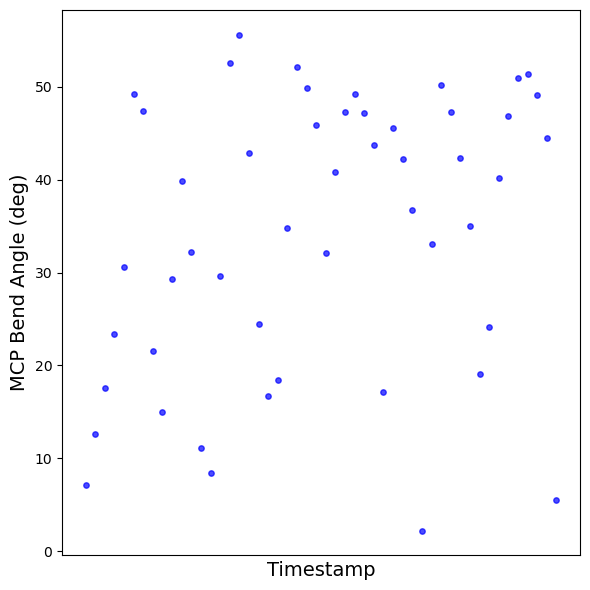

In [117]:
# Plot MCP Bend Angles Calculated from Camera Data vs Camera Timestamp
plt.figure(figsize=(6,6))
plt.scatter(
    cam.df[("ts_25183199", "", "")], 
    cam.df[("metric", "mcp_bend_deg", "deg")],
    s=15, alpha=0.7, color="blue"  # set dots to blue
)

plt.xlabel("Timestamp", fontsize=14)  # bigger label font
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)

# Remove x ticks completely
plt.xticks([])

plt.tight_layout()
plt.savefig("MCP Bend vs timestamp.png", dpi=300, bbox_inches='tight')
plt.show()


In [118]:
cam.df[("ts_25183199", "", "")]

10     183711630117
12     183711730869
13     183711781214
14     183711828883
15     183711879401
18     183712033450
20     183712134289
24     183712335715
25     183712383549
33     183712789455
39     183713089956
52     183713747731
61     183714201057
66     183714450744
69     183714605585
90     183715663678
91     183715713977
94     183715865618
96     183715965974
97     183716013728
104    183716369041
106    183716467540
109    183716621190
110    183716671216
111    183716721712
124    183717376824
125    183717427116
126    183717477408
127    183717528051
128    183717577688
129    183717628838
141    183718230479
147    183718532703
148    183718585881
149    183718633656
155    183718935756
162    183719290941
166    183719497926
167    183719543059
168    183719593828
169    183719644110
171    183719744797
179    183720145276
181    183720248900
182    183720299252
183    183720346870
184    183720397207
185    183720447474
186    183720497922
198    183721105458


In [119]:
df_renc["timestamp"]

0      183711116203
1      183711140863
2      183711163313
3      183711188072
4      183711212366
           ...     
435    183721011690
436    183721033034
437    183721057496
438    183721079570
439    183721103034
Name: timestamp, Length: 440, dtype: int64

## Align Timestamps 

In [121]:
cam.find_matching_indices(
    encoder_df=df_renc,
    cam_time_col=("ts_25183199", "", ""),  # or "ts_25183199"
    enc_time_col="timestamp",

    #--------------- set a timestamp difference threshold here ------------------
    
    tolerance="50ms",     # <-- was 10000; use an explicit window for clarity

    #--------------- set a timestamp difference threshold here ------------------
    
    direction="nearest",
)

cam.attach_encoder_using_match(
    encoder_df=df_renc,
    columns=None,
    suffix="_renc",
    keep_time_delta=True,
    drop_unmatched=True,
)


[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 18:37:11.630117 → 0 days 18:37:21.105458
[debug] enc range: 0 days 18:37:11.116203 → 0 days 18:37:21.103034
[debug] probe |delta| (ms) stats: count    25.000000
mean      6.337880
std       3.594069
min       1.002000
25%       4.221000
50%       5.289000
75%       7.570000
max      17.550000
Name: delta_ms, dtype: float64


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:355: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:356: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


,"(scorer, bodyparts, coords)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, PIP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, MCP, likelihood)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, x)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, y)","(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, hand, likelihood)",...,"(DLC_Resnet50_0815Aug16shuffle1_snapshot_010, forearm, likelihood)","(ts_25183199, , )","(ts_25185174, , )","(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)",timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
10,10,302.43457,202.744310,0.808667,773.65890,349.33536,0.934922,907.30290,409.89774,0.810736,...,0.883491,183711630117,183711643191,7.098067,9.001092,183711625537,14504,2.719500,0.557797,-4.580
12,12,289.64570,249.260800,0.808010,771.20420,348.44480,0.952226,908.20294,410.23070,0.821622,...,0.916817,183711730869,183711744295,12.637036,8.868980,183711721077,13662,2.561625,-9.162752,-9.792
13,13,290.83620,289.432860,0.848509,770.13434,347.05292,0.953916,908.01337,409.78960,0.824172,...,0.892086,183711781214,183711789925,17.611065,9.090897,183711788683,12716,2.384250,-20.083939,7.469
14,14,306.35022,339.602230,0.846708,769.22730,346.87604,0.878924,907.54535,409.36478,0.816526,...,0.890846,183711828883,183711837847,23.412007,8.943075,183711831429,11862,2.224125,-29.943023,2.546
15,15,336.94165,394.081420,0.814891,770.28520,346.16050,0.913531,908.52527,408.65042,0.813333,...,0.872115,183711879401,183711886599,30.635194,8.945403,183711877291,11028,2.067750,-39.571216,-2.110
18,18,450.21090,502.261700,0.868349,783.78280,348.84415,0.913854,923.19480,412.49283,0.800273,...,0.849328,183712033450,183712043194,49.237925,8.831360,183712040325,9099,1.706063,-61.840740,6.875
20,20,456.42844,499.790370,0.917657,805.90784,353.92430,0.818139,946.30536,418.76743,0.803987,...,0.863766,183712134289,183712144774,47.444765,8.946291,183712129988,9405,1.763437,-58.308094,-4.301
24,24,304.60138,327.063660,0.818308,773.64900,349.02698,0.917453,912.62600,411.45587,0.808506,...,0.924498,183712335715,183712346239,21.508824,8.855295,183712331161,12504,2.344500,-22.531393,-4.554
25,25,289.68494,266.963700,0.814775,772.44350,346.82565,0.949207,910.12140,409.34470,0.800618,...,0.823081,183712383549,183712393530,15.029356,9.130542,183712375643,13298,2.493375,-13.364985,-7.906
33,33,335.91806,386.237640,0.853279,774.68726,346.91318,0.915733,912.88200,408.83480,0.804914,...,0.872665,183712789455,183712798826,29.257383,9.213675,183712779107,11382,2.134125,-35.484429,-10.348


In [122]:
# Create a smaller dataframe keeping only columns for following:

cols_to_keep = [
    "angle_renc",   
    ("metric", "mcp_bend_deg", "deg"),
    ("metric", "wrist_bend_deg", "deg"),
    "time_delta_renc",  # time difference between camera and rot enc timestamps
]
small_df = cam.df[cols_to_keep].copy()
small_df = small_df.dropna(subset=[("metric", "mcp_bend_deg", "deg")])
small_df = small_df.loc[:, ~small_df.columns.duplicated()].copy()


In [123]:
# Count how many remaining datapoints left  in MCP Bend Angle  after NaN removal from timestamped matched dataframe 

# Count NaNs
remain = len(small_df)

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"Rows after timestamp matching: {total_rows} rows")
print(f"Rows after dropping NaN's in MCP Bend Angle: {remain} rows")

Rows after timestamp matching: 50 rows
Rows after dropping NaN's in MCP Bend Angle: 50 rows


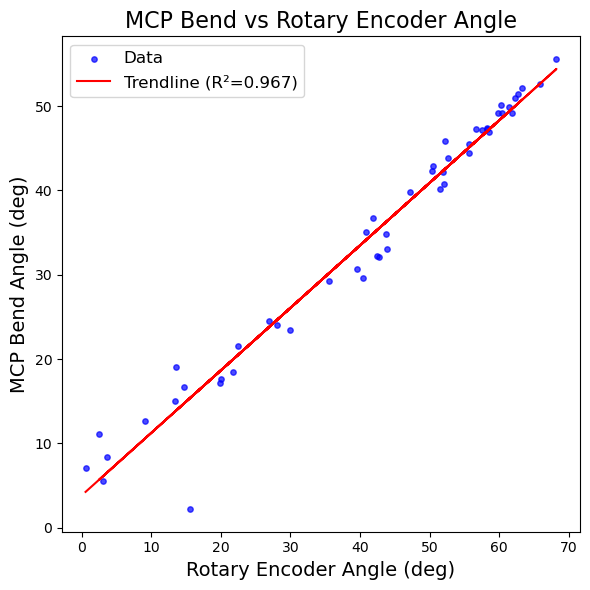

In [124]:
x = small_df["angle_renc"].to_numpy()
y = small_df[("metric", "mcp_bend_deg", "deg")].to_numpy()

# in-place (no extra array)
np.abs(x, out=x)

# Fit linear regression (y = m*x + b)
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# Compute R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=15, alpha=0.7, color="blue", label="Data")  # blue dots
plt.plot(x, y_pred, color="red", label=f"Trendline (R²={r2:.3f})")

plt.xlabel("Rotary Encoder Angle (deg)", fontsize=14)  # bigger labels
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.title("MCP Bend vs Rotary Encoder Angle", fontsize=16)

plt.grid(False)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("MCP Bend vs rot enc.png", dpi=300, bbox_inches='tight')
plt.show()


## This code is calculating abs error between camera calculated mcp bend angle (pred) and encoder angle (true).  This is not taking into account angles where plate is bend up.  Also, i am including all timestamp matched data, even where likelihood column showed values of ~ 0.7. 

C:\Users\toppe\AppData\Local\Temp\ipykernel_22192\233227894.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


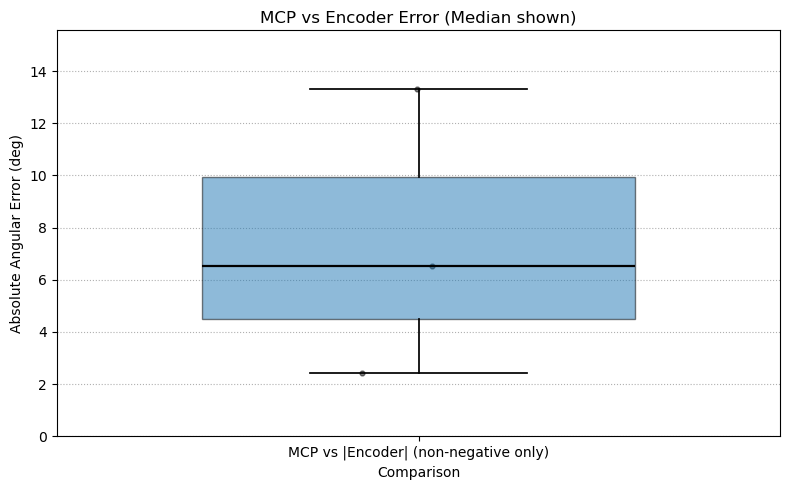

In [126]:
# --- columns in cam.df ---
mcp_angle_col = ("metric", "mcp_bend_deg", "deg")  # adjust if different
enc_angle_col = "angle_renc"
time_col      = "timestamp"  # optional

# --- pull numeric columns ---
mcp = pd.to_numeric(cam.df[mcp_angle_col], errors="coerce")
enc = pd.to_numeric(cam.df[enc_angle_col], errors="coerce")

# --- drop rows with NaN ---
mask = mcp.notna() & enc.notna()
mcp = mcp[mask]
enc = enc[mask]
ts  = cam.df.loc[mask, time_col] if time_col in cam.df.columns else None

# --- drop rows where encoder is negative ---
mask_pos = enc >= 0
mcp = mcp[mask_pos].to_numpy()
enc = enc[mask_pos].to_numpy()
ts  = ts[mask_pos].to_numpy() if ts is not None else None

# --- absolute value of encoder for truth ---
enc_abs = np.abs(enc)

# --- absolute error (true = |encoder|, exp = MCP) ---
aerr = np.abs(mcp - enc_abs)

# --- optional tidy DataFrame ---
df_err = pd.DataFrame({
    enc_angle_col: enc_abs,
    mcp_angle_col: mcp,
    "abs_error_deg": aerr
})
if ts is not None:
    df_err[time_col] = ts

# --- box plot: median shown (default), mean hidden ---
fig, ax = plt.subplots(figsize=(8, 5))

bp = ax.boxplot(
    [aerr],
    labels=["MCP vs |Encoder| (non-negative only)"],
    patch_artist=True,
    showfliers=False,
    showmeans=False,
    widths=0.6
)

# style
for patch in bp["boxes"]:
    patch.set_facecolor("#1f77b4")
    patch.set_alpha(0.5)
    patch.set_edgecolor("black")
for med in bp["medians"]:
    med.set_color("black"); med.set_linewidth(1.6)
for w in bp["whiskers"]:
    w.set_color("black"); w.set_linewidth(1.25)
for cap in bp["caps"]:
    cap.set_color("black"); cap.set_linewidth(1.25)

# jittered points (optional)
x = np.random.normal(loc=1, scale=0.04, size=aerr.size)
ax.scatter(x, aerr, s=12, alpha=0.5, color="black")

# axes/limits
ax.set_xlabel("Comparison")
ax.set_ylabel("Absolute Angular Error (deg)")
if aerr.size:
    ymax = np.nanpercentile(aerr, 97.5) * 1.2
    ax.set_ylim(0, max(15, ymax))
ax.set_title("MCP vs Encoder Error (Median shown)")

ax.grid(True, axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()
